# TAREA # 1: COMPRENDER EL PROBLEMA Y EL CASO PRÁCTICO


<table>
  <tr><td>
    <img src="https://drive.google.com/uc?id=15eGnAbma5Q_j9CZZKi46Gh3-EpgSWYOV"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Figura 1. Clasificación de Enfermedades utilizando Deep Learning 
  </td></tr>
</table>


# TAREA # 2: IMPORTAR LIBRERÍAS Y CONJUNTO DE DATOS

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# Necesitarás montar tu disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, consulta esto: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Especificar el directorio del conjunto de entrenamiento
XRay_Directory = "/content/drive/MyDrive/DL_Dataset/Dataset"

In [ ]:
# Listar las carpetas de dicho directorio
os.listdir(XRay_Directory)

['3', '2', '1', '0']

In [ ]:
# Utilizar el generador de imágenes para generar datos de imágenes de tensores y normalizarlos
# Utilizar el 20% de los datos para la validación cruzada posterior
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [ ]:
# Genere lotes de 40 imágenes
# El número total de imágenes es 133 * 4 = 532 imágenes
# El entrenamiento usará es 428 (80%) y la validación usará 104 (20%)
# Realizar muestreo aleatoria y cambio del tamaño en las imágenes
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "training")

Found 428 images belonging to 4 classes.


In [ ]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = XRay_Directory, shuffle = True,
                                                      target_size = (256, 256), class_mode = "categorical", subset = "validation")

Found 104 images belonging to 4 classes.


In [ ]:
# Generar un lote de 40 imágenes y etiquetas
train_images, train_labels = next(train_generator)

In [ ]:
train_images.shape

(40, 256, 256, 3)

In [ ]:
train_labels.shape

(40, 4)

In [ ]:
train_labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]],

In [ ]:
# Traducción de cada Etiqueta
label_names = {0: 'COVID-19', 1: 'Normal', 2: 'Pneumonia Virica', 3: 'Pneumonia Bacteriana'}

# TAREA #3: VISUALIZACIÓN DEL DATASET

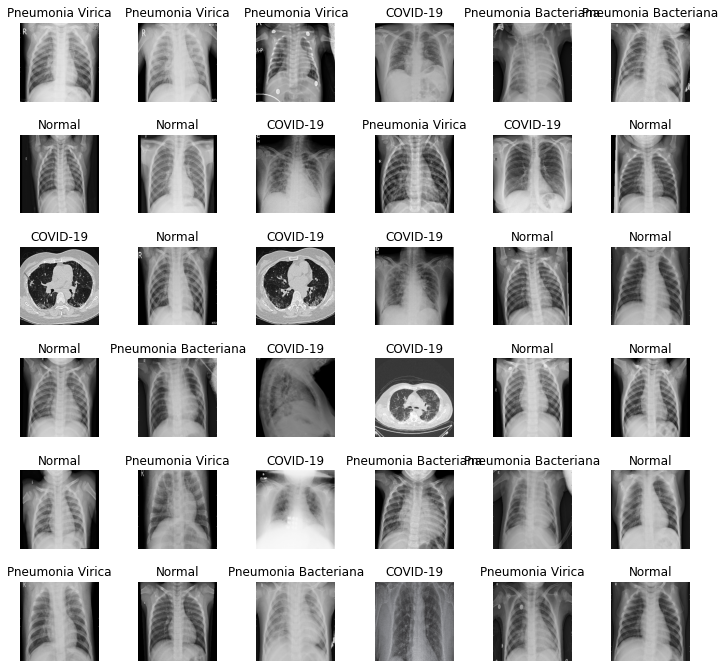

In [ ]:
# Crea una matriz de 36 imágenes junto con sus etiquetas correspondientes
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# TAREA #3: IMPORTAR EL MODELO CON PESOS PRE ENTRENADOS

In [ ]:
basemodel = ResNet50(weights = "imagenet", include_top = False, input_tensor = Input(shape = (256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Congelar el modelo hasta las últimas etapas - 4 y llevar a cabo un re entrenamiento -5 
for layer in basemodel.layers[:-10]:
    layer.trainable = False

# TAREA #4 : CONSTRUIR Y ENTRENAR UN MODELO DE DEEP LEARNING

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4, decay = 1e-6), metrics = ["accuracy"])

In [ ]:
# Usar la parada temprana (early stopping) para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Almacenar el mejor modelo con la menor pérdida en la validación
checkpointer = ModelCheckpoint(filepath = "weights.hdf5", verbose = 1, save_best_only=True)

In [ ]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "training")
val_generator = image_generator.flow_from_directory(batch_size=4, directory = XRay_Directory, shuffle = True, target_size=(256, 256), class_mode = "categorical", subset = "validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=train_generator.n//4, epochs = 25, 
                              validation_data = val_generator, validation_steps = val_generator.n // 4,
                              callbacks = [checkpointer, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 1.4169 - accuracy: 0.3458
Epoch 00001: val_loss improved from inf to 1.37288, saving model to weights.hdf5
107/107 [==============================] - 224s 2s/step - loss: 1.4169 - accuracy: 0.3458 - val_loss: 1.3729 - val_accuracy: 0.4712
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.0956 - accuracy: 0.5210
Epoch 00002: val_loss improved from 1.37288 to 1.21422, saving model to weights.hdf5
107/107 [==============================] - 11s 103ms/step - loss: 1.0956 - accuracy: 0.5210 - val_loss: 1.2142 - val_accuracy: 0.3846
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9799 - accuracy: 0.5888
Epoch 00003: val_loss improved from 1.21422 to 1.04853, saving model to weights.hdf5
107/107 [==============================] - 11s 103ms/step - loss: 0.9799 - accuracy: 0.5888 - val_loss: 1.0485 - val_ac

# TAREA #5: EVALUAR EL MODELO DE DEEP LEARNING ENTRENADO

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

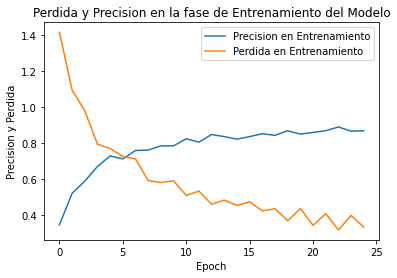

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title("Perdida y Precision en la fase de Entrenamiento del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision y Perdida")
plt.legend(["Precision en Entrenamiento", "Perdida en Entrenamiento"])

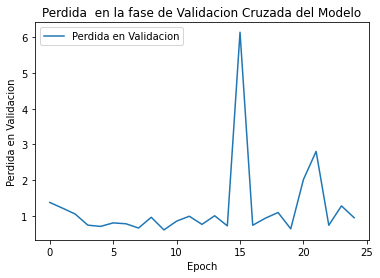

In [ ]:
plt.plot(history.history['val_loss'])

plt.title("Perdida  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Perdida en Validacion")
plt.legend(["Perdida en Validacion"])

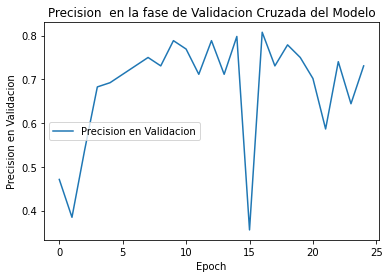

In [ ]:
plt.plot(history.history['val_accuracy'])

plt.title("Precision  en la fase de Validacion Cruzada del Modelo")
plt.xlabel("Epoch")
plt.ylabel("Precision en Validacion")
plt.legend(["Precision en Validacion"])

In [ ]:
test_directory = "/content/drive/MyDrive/DL_Dataset/Test"

In [ ]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode="categorical")

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose = 1)

print("Precision en la fase de Test : {}".format(evaluate[1]))

Found 40 images belonging to 4 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 0s 46ms/step - loss: 1.9320 - accuracy: 0.6000
Precision en la fase de Test : 0.6000000238418579


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [ ]:
len(original)

40

In [ ]:
score = accuracy_score(original, prediction)
print("Eficacia de la prediccion {}".format(score))

Eficacia de la prediccion 0.6


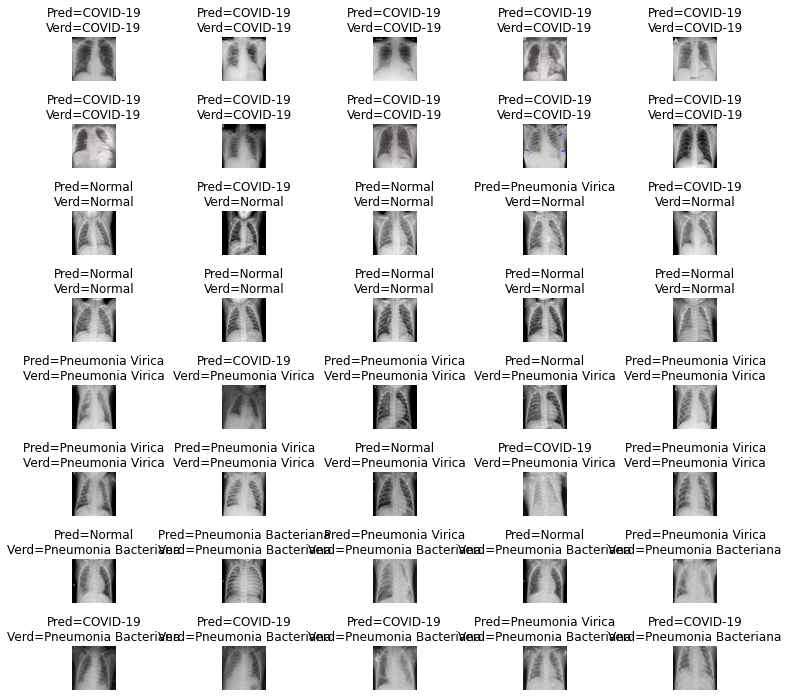

In [ ]:
L = 8
W = 5

fig, axes = plt.subplots(L, W, figsize = (12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title("Pred={}\nVerd={}".format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2, hspace=1)

In [ ]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.64      0.70      0.67        10
           2       0.60      0.60      0.60        10
           3       1.00      0.10      0.18        10

    accuracy                           0.60        40
   macro avg       0.70      0.60      0.54        40
weighted avg       0.70      0.60      0.54        40



Text(0.5, 1.0, 'Matriz de Confusion')

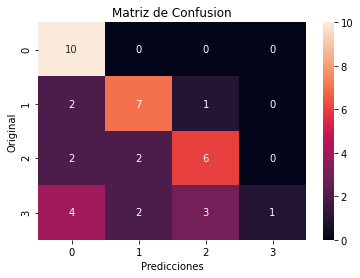

In [ ]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel("Predicciones")
ax.set_ylabel("Original")
ax.set_title("Matriz de Confusion")